In [10]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import skimage
from einops import rearrange
from tqdm import tqdm


pv.set_jupyter_backend("static")

datadir = Path("../data/SIM")


def read_SIM_data(filepath: Path | str):
    f = h5py.File(filepath)
    data = f["Data"][:]
    pixel_sizes = f["Data"].attrs["pixel_sizes"]
    dtype = data.dtype
    if dtype.kind == "u":
        data = data / np.iinfo(dtype).max
    return data, pixel_sizes


In [11]:
data, pixel_sizes = read_SIM_data(datadir / "alpha-actinin/Image2_SIM2.h5")
data = data[..., 0:1024, 1024:2048]
data_chunks = rearrange(data, "C Z (Ny Y) (Nx X) -> (Ny Nx) C Z Y X", Ny=2, Nx=2)
data = data_chunks[0]

In [3]:
data.shape

(2, 45, 512, 512)

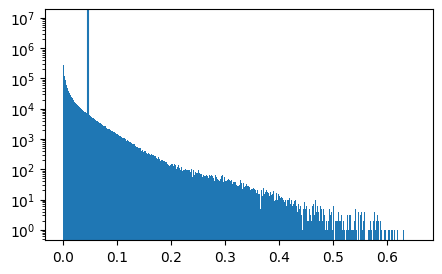

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(data[1, :].flatten(), bins=1000)
# ax.set_yscale("log")
ax.axvline(skimage.filters.threshold_otsu(data[1, :]))
ax.set_yscale("log")

In [76]:
thresholds

array([0.02975712, 0.11079778])

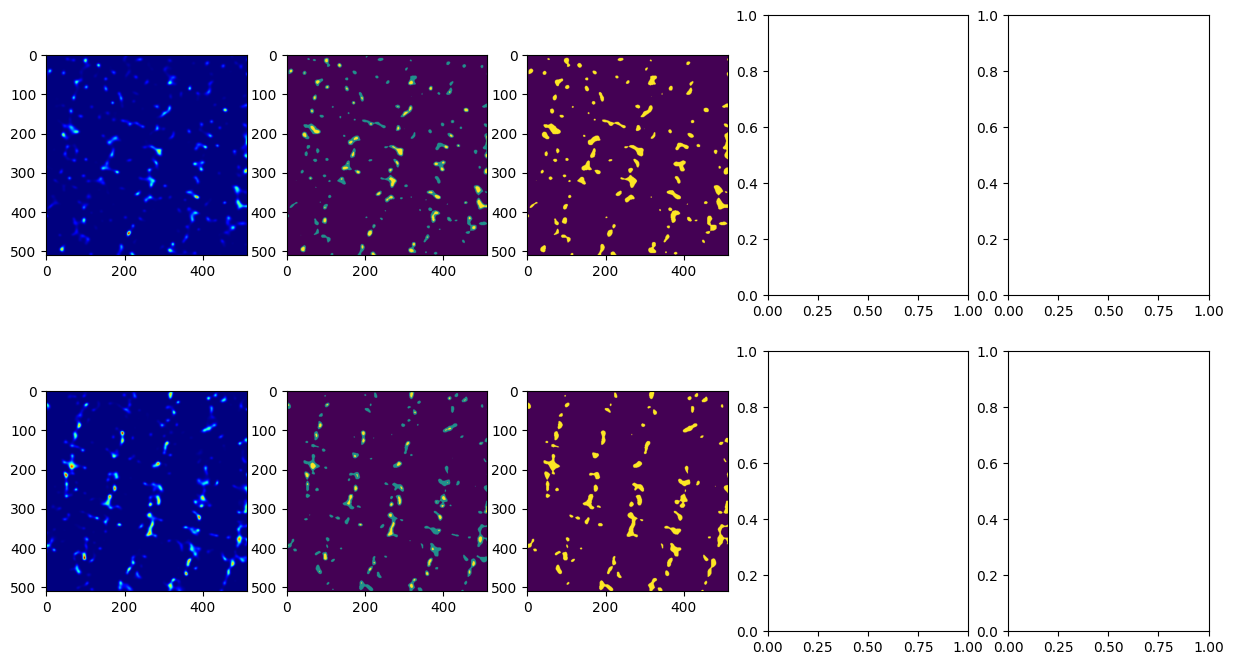

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i, axes_row in enumerate(axes):
    img = data[i]
    thresholds = skimage.filters.threshold_multiotsu(img)
    bin = skimage.filters.apply_hysteresis_threshold(img, *thresholds)
    # seg = skimage.segmentation.morphological_chan_vese(
    #     img, num_iter=40, init_level_set=img > thresholds[0], smoothing=1
    # )

    axes_row[0].imshow(img[10], cmap="jet")
    axes_row[1].imshow(np.digitize(img, bins=thresholds)[10])
    axes_row[2].imshow(bin[10])
    # axes_row[3].imshow(seg[10])
    # axes_row[4].imshow(seg[10] - bin[10])


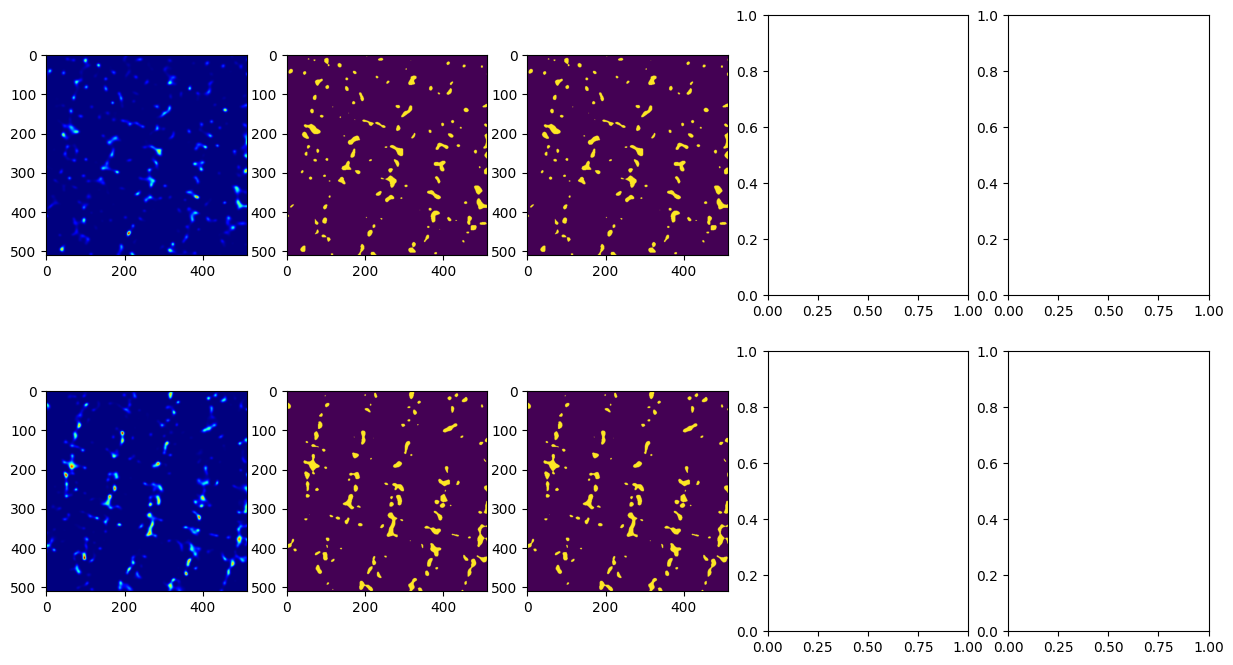

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i, axes_row in enumerate(axes):
    img = data[i]
    threshold = skimage.filters.threshold_otsu(img)
    bin = skimage.filters.apply_hysteresis_threshold(img, 0.75 * threshold, threshold)
    # seg = skimage.segmentation.morphological_chan_vese(
    #     img, num_iter=40, init_level_set=img > thresholds[0], smoothing=1
    # )

    axes_row[0].imshow(img[10], cmap="jet")
    axes_row[1].imshow(img[10] > 0.75 * threshold)
    axes_row[2].imshow(bin[10])
    # axes_row[3].imshow(seg[10])
    # axes_row[4].imshow(seg[10] - bin[10])


In [95]:
def segment_image(img: np.ndarray):
    bin = img > skimage.filters.threshold_otsu(img)
    return skimage.segmentation.morphological_chan_vese(
        img, num_iter=40, init_level_set=bin, smoothing=2
    )


actinin_segmented = np.stack([segment_image(img) for img in tqdm(data[0])], axis=0)
actinin_segmented.shape

100%|██████████| 45/45 [06:06<00:00,  8.14s/it]


(45, 1024, 1024)

In [19]:
img = data[1]
actinin_segmented = skimage.filters.apply_hysteresis_threshold(
    img, *skimage.filters.threshold_multiotsu(img)
)
# otsu = skimage.filters.threshold_otsu(img)
# actinin_segmented = skimage.filters.apply_hysteresis_threshold(img, 0.7 * otsu, otsu)


In [15]:
actinin_segmented.shape

(45, 512, 512)

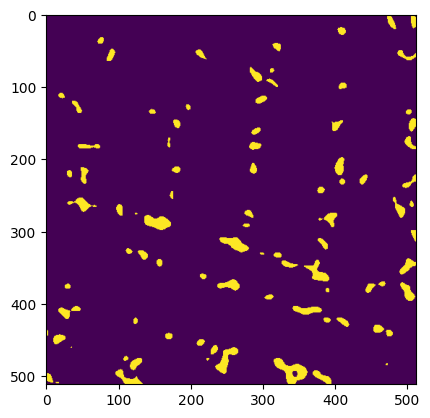

In [20]:
plt.imshow(actinin_segmented[20])

In [21]:
verts, faces, normals, values = skimage.measure.marching_cubes(
    np.permute_dims(actinin_segmented, (2, 1, 0)), level=0.5, spacing=pixel_sizes[::-1]
)

In [22]:
verts.shape

(326172, 3)

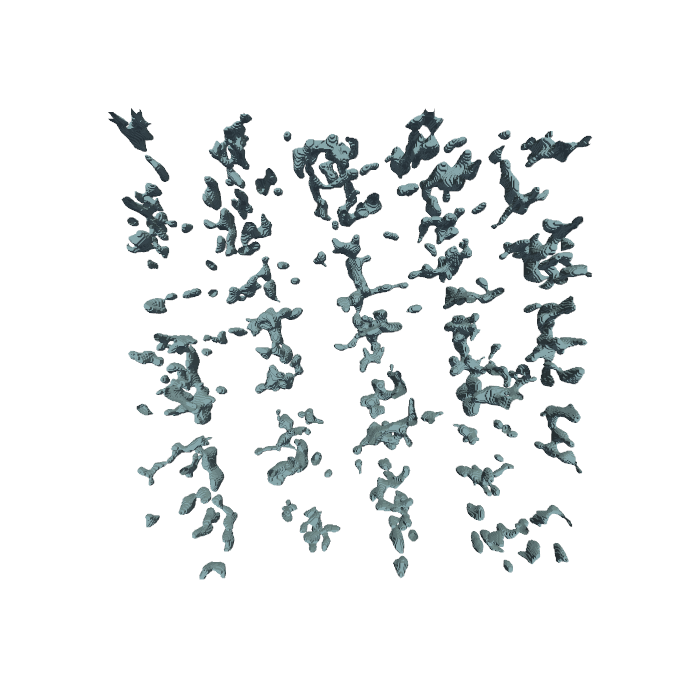

In [23]:
import pyvista as pv


mesh = pv.PolyData.from_regular_faces(verts, faces)

pl = pv.Plotter(notebook=True, window_size=(700, 700))
pl.add_mesh(mesh)
pl.view_xy()
pl.show()

In [7]:
skeleton = skimage.morphology.skeletonize(actinin_segmented)
skeleton.shape

(45, 512, 512)

{(np.int64(0),
  np.int64(5),
  np.int64(438)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154f2f23b0b0>,
 (np.int64(0),
  np.int64(6),
  np.int64(437)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154eb991a390>,
 (np.int64(0),
  np.int64(7),
  np.int64(436)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154ec64979b0>,
 (np.int64(0),
  np.int64(8),
  np.int64(435)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154eb991d6a0>,
 (np.int64(0),
  np.int64(9),
  np.int64(435)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154eb9930e60>,
 (np.int64(0),
  np.int64(294),
  np.int64(277)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154eb99316d0>,
 (np.int64(1),
  np.int64(2),
  np.int64(206)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154eb99321e0>,
 (np.int64(1),
  np.int64(3),
  np.int64(439)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154eb99329f0>,
 (np.int64(1),
  np.int64(4),
  np.int64(438)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection a

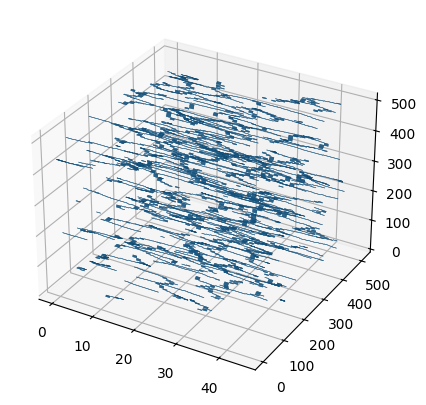

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.voxels(skeleton)

In [9]:
thresholds

NameError: name 'thresholds' is not defined